data preparation:

In [110]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

In [111]:
# constants:
GESTURE_NUM = 13
VCC = 5

In [112]:
# load data
ges_dfs = [[i] for i in range(GESTURE_NUM)]
folder_path = ".\\gesture_data\\"
for i in range(GESTURE_NUM):
    file_path = folder_path + f"gesture{i+1}.csv"
    df = pd.read_csv(file_path)
    zero_rows = (df == 0).all(axis=1)
    zero_rows_indexes = list(zero_rows[zero_rows].index)
    ges_df_list = []
    ges_dfs[i].pop()
    start = 0
    for j in range(len(zero_rows_indexes)):
        ges_df = df.iloc[start:zero_rows_indexes[j],:]
        start = zero_rows_indexes[j] + 1
        ges_df_list.append(ges_df)     
    ges_dfs[i].extend(ges_df_list)

len(ges_dfs),len(ges_dfs[0])

(13, 390)

In [113]:
ges_dfs[0][0].shape

(14, 10)

In [114]:
# get time-step in lstm
time_step =zero_rows_indexes[1] - zero_rows_indexes[0] - 1 # remove all-zero row
time_step

14

In [115]:
def set_shuffle(setX:list,setY:list):
    """
    shuffle setX and setY, but still keep setX and setY's mapping
    return:
       setX,setY
    """
    import random
    ges_set = list(zip(setY,setX))
    keys = [i+1 for i in range(len(ges_set))]
    ges_set_dict = dict(zip(keys,ges_set))
    random.shuffle(keys)
    setX = []
    setY = []
    for i in range(len(keys)):
        ges_sample = ges_set_dict[keys[i]]
        setX.append(ges_sample[1])
        setY.append(ges_sample[0])
    return setX,setY

In [116]:
# get training set, CV set and testing set:
ges_trainingX = []
ges_trainingY = []
ges_validationX = []
ges_validationY = []
ges_testingX = []
ges_testingY = []


for i in range(GESTURE_NUM):
    CV_split = round(len(ges_dfs[i]) * 0.30)
    test_split = round(len(ges_dfs[i]) * 0.10) 
    ges_trainingX.extend(ges_dfs[i][:len(ges_dfs[i])-CV_split]) # training set
    ges_validationX.extend(ges_dfs[i][len(ges_dfs[i])-CV_split:len(ges_dfs[i])-test_split]) # validation set
    ges_testingX.extend(ges_dfs[i][len(ges_dfs[i])-test_split:]) # test set

    ges_trainingY.extend([i+1]*(len(ges_dfs[i])-CV_split))
    ges_validationY.extend([i+1]*((len(ges_dfs[i])-test_split)-(len(ges_dfs[i])-CV_split)))
    ges_testingY.extend([i+1]*test_split)

# shuffle training and testing set
ges_trainingX,ges_trainingY = set_shuffle(ges_trainingX,ges_trainingY)
ges_validationX,ges_validationY = set_shuffle(ges_validationX,ges_validationY)
ges_testingX,ges_testingY = set_shuffle(ges_testingX,ges_testingY)


In [117]:
# shape of all sets:
print("trainX shape--","(",len(ges_trainingX),",",ges_trainingX[0].shape,")")
print("CV_X shape-- ","(",len(ges_validationX),",",ges_validationX[0].shape,")")
print("testX shape--","(",len(ges_testingX),",",ges_testingX[0].shape,")")

trainX shape-- ( 3549 , (14, 10) )
CV_X shape--  ( 1014 , (14, 10) )
testX shape-- ( 507 , (14, 10) )


In [118]:
def transfrom_flex_raw(setX):
    setX = setX.copy()
    setX.iloc[:,:5] = setX.iloc[:,:5] * 5 / 1023.0
    return setX

In [119]:
from sklearn.preprocessing import MinMaxScaler

In [120]:
# concat all training data in X, and do normalization:
ges_trainingX_df = pd.concat(ges_trainingX)
ges_validationX_df = pd.concat(ges_validationX)
ges_testingX_df = pd.concat(ges_testingX)
# #用于后续性能优化：让analog pin口读数转为电压
# ges_trainingX_df = transfrom_flex_raw(ges_trainingX_df)
# ges_testingX_df = transfrom_flex_raw(ges_testingX_df)

# transfrom flex sensor data to voltage:

scaler = MinMaxScaler(feature_range=(0,1))
ges_trainingX_scaled = scaler.fit_transform(ges_trainingX_df)
ges_validationX_scaled = scaler.fit_transform(ges_validationX_df)
ges_testingX_scaled = scaler.fit_transform(ges_testingX_df)

In [121]:
ges_trainingX_scaled.shape,ges_validationX_scaled.shape,ges_testingX_scaled.shape

((49686, 10), (14196, 10), (7098, 10))

In [122]:
def splitX(dataset,time_step):
    dataX = []
    for i in range(time_step,len(dataset)+time_step,time_step):
        dataX.append(dataset[i-time_step:i,0:dataset.shape[1]]) 
    return np.array(dataX)

In [123]:

ges_trainingX = splitX(ges_trainingX_scaled,time_step)
ges_trainingY = np.array(ges_trainingY) # generate an one-hot encoding for labels, this encoding is a dim=14 vector, where first element points to label=0(however, no label here =0)
ges_validationX = splitX(ges_validationX_scaled,time_step)
ges_validationY = np.array(ges_validationY)
ges_testingX = splitX(ges_testingX_scaled,time_step)
ges_testingY = np.array(ges_testingY)

In [124]:
# view shapes
print("trainX Shape-- ",ges_trainingX.shape)
print("trainY Shape-- ",ges_trainingY.shape)
print("CV_X Shape-- ",ges_validationX.shape)
print("CV_Y Shape-- ",ges_validationY.shape)
print("testX Shape-- ",ges_testingX.shape)
print("testY Shape-- ",ges_testingY.shape)


trainX Shape--  (3549, 14, 10)
trainY Shape--  (3549,)
CV_X Shape--  (1014, 14, 10)
CV_Y Shape--  (1014,)
testX Shape--  (507, 14, 10)
testY Shape--  (507,)


In [125]:
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler

In [126]:
# 将 NumPy 数组转换为 PyTorch Tensor
trainX_tensor = torch.tensor(ges_trainingX,dtype=torch.float32)
trainY_tensor = torch.tensor(ges_trainingY,dtype=torch.float32)
validationX_tensor = torch.tensor(ges_validationX,dtype=torch.float32)
validationY_tensor = torch.tensor(ges_validationY,dtype=torch.float32)
testX_tensor = torch.tensor(ges_testingX,dtype=torch.float32)
testY_tensor = torch.tensor(ges_testingY,dtype=torch.float32)

# 创建 TensorDataset
train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
CV_dataset = TensorDataset(validationX_tensor,validationY_tensor)
test_dataset = TensorDataset(testX_tensor, testY_tensor)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
CV_loader = DataLoader(CV_dataset,batch_size=16,shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # 测试集通常不打乱

Model training：

In [127]:
torch.manual_seed(3407)

In [128]:
# constants
num_layers = 1  #一层lstm
num_directions = 2  #双向lstm
lr = 1e-3 # 学习率
batch_size = 16   
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
num_classses =GESTURE_NUM+1
time_step = 14
input_size = 10
hidden_size = 100 # how many hidden layer on LSTM

In [130]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size,hidden_size, num_layers, num_directions, num_classes,dropout_prob):
        super(BiLSTMModel, self).__init__()

        self.input_size = input_size # 数据维度
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = num_directions
        
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, 
                             num_layers = num_layers, bidirectional = (num_directions == 2))
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, 
                             num_layers = num_layers, bidirectional = (num_directions == 2))
        self.dropout = nn.Dropout(dropout_prob)
        self.attention_weights_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True)
        )
        self.liner = nn.Linear(hidden_size, num_classes)
        self.act_func = nn.Softmax(dim=1)
    
    def forward(self,x):
        """
        x: input data with shape: [batch_size, time_step, embedding_size]
        """
        #x [batch_size, time_step, embedding_size]
        x = x.permute(1, 0, 2) #[time_step, batch_size, embedding_size]
        #LSTM 期望将时间步放在最前面        
        #由于数据集不一定是预先设置的batch_size的整数倍，所以用size(1)获取当前数据实际的batch
        batch_size = x.size(1)

        # LSTM最初的前向输出，即记忆单元C和隐状图H
        h_0 = torch.randn(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)

        # 第一层LSTM
        #out[seq_len, batch, num_directions * hidden_size]。多层lstm，out是每个时间步t的输出h_t
        #h_n, c_n [num_layers(1) * num_directions, batch, hidden_size]，h_n是当前层最后一个隐状态输出
        out, (h_n, c_n) = self.lstm1(x, (h_0, c_0))
        # 第一层Dropout，
        out = self.dropout(out)
        #双向LSTM输出拆成前向和后向输出
        #将双向lstm的输出拆分为前向输出和后向输出
        (forward_out, backward_out) = torch.chunk(out, 2, dim = 2)
        out = forward_out + backward_out  #[seq_len, batch, hidden_size]

         # 第二层LSTM
        out, (h_n, c_n) = self.lstm2(out, (h_n, c_n))
        # 第二层Dropout
        out = self.dropout(out)
        
        # 再次将双向LSTM的输出拆分为前向输出和后向输出，并求和
        (forward_out, backward_out) = torch.chunk(out, 2, dim=2)
        out = forward_out + backward_out  # [seq_len, batch, hidden_size]
    
        # 调整out的维度以符合后续处理的要求
        out = out.permute(1, 0, 2)  # [batch, seq_len, hidden_size]
        #print("LSTM out",out)
         #为了使用到lstm最后一个时间步时每层lstm的表达，用h_n生成attention的权重
        h_n = h_n.permute(1, 0, 2)  #[batch, num_layers * num_directions,  hidden_size]
        h_n = torch.sum(h_n, dim=1) #[batch, 1,  hidden_size]
        h_n = h_n.squeeze(dim=1)  #[batch, hidden_size]
        # 得到attention层的权重
        attention_w = self.attention_weights_layer(h_n)  #[batch, hidden_size]
        attention_w = attention_w.unsqueeze(dim=1) #[batch, 1, hidden_size]
        m = nn.Tanh()(out)
        # torch.bmm: 矩阵乘法,下文m.transpose(1,2)就是将原来维度从 [batch, seq_len, hidden_size] 转换为 [batch, hidden_size, seq_len]，以方便下面进行矩阵乘法
        attention_context = torch.bmm(attention_w, m.transpose(1, 2))  #[batch, 1, seq_len]
        #print("attention_context",x,sep='\n')
        softmax_w = F.softmax(attention_context, dim=-1)  #[batch, 1, seq_len], 用softmax对刚才的权重归一化,a-> a'
        
        x = torch.bmm(softmax_w, out)  #[batch, 1, hidden_size] 抽取sequence内的重要信息
        x = x.squeeze(dim=1)  #[batch, hidden_size]
        #print("after squeeze:",x,sep='\n')
        x = self.liner(x)
        #x = self.act_func(x)
        return x
        

In [131]:
def test(model, test_loader, loss_func):
    model.eval()
    loss_val = 0.0
    corrects = 0.0
    for datas, labels in test_loader:
        datas = datas.to(device)
        labels = labels.to(device)
        
        preds = model(datas)
        loss = loss_func(preds, labels.long())
        loss_val += loss.item() * datas.size(0)
        
        #获取预测的最大概率出现的位置
        preds = nn.Softmax(dim=1)(preds)
        preds = torch.argmax(preds, dim=1)
        #labels = torch.argmax(labels, dim=0)
        corrects += torch.sum(preds == labels).item()
    test_loss = loss_val / len(test_loader.dataset) # 计算整个测试集的总损失
    test_acc = corrects / len(test_loader.dataset) # 计算整个测试集的总正确率
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    return test_loss,test_acc

In [132]:
def train(model, train_loader,test_loader,optimizer, loss_func, epochs):
    """
    define training process of upon model
    return:
    model: the model after training
    train_loss_epochs: loss for each epoch in training
    train_acc_epochs: accuracy for each epoch in training
    CV_loss_epochs: loss for each epoch in validation
    CV_acc_epochs: accuracy for each epoch in validation
    """
    best_val_acc = 0.0
    best_model_params = copy.deepcopy(model.state_dict())
    # 记录训练损失和正确率，用于画图：
    train_loss_epochs = []
    train_acc_epochs = []
    # 记录每次验证的损失和正确率，用于画图：
    CV_loss_epochs = []
    CV_acc_epochs = []
    for epoch in range(epochs):
        print(f" epoch{epoch+1}:...")
        model.train() # 设置为训练模式
        loss_val = 0.0
        corrects = 0.0
        for datas, labels in train_loader:
            # datas: (batch_size,input_size(14),features(10))
            # labels: (batch_size,input_size(14))
            datas = datas.to(device)
            labels = labels.to(device)
            
            preds = model(datas) # 前向传播
            #print(labels.long())
            loss = loss_func(preds, labels.long()) # 计算损失,tensor大小是1
            
            optimizer.zero_grad() # 清除优化器梯度（来自于上一次反向传播）
            loss.backward() # 反向传播, 计算模型参数梯度
            optimizer.step() # 根据计算得到的梯度，使用优化器更新模型的参数。
            
            loss_val += loss.item() * datas.size(0) #获取loss，并乘以当前批次大小
            
            #获取预测的最大概率出现的位置
            preds = nn.Softmax(dim=1)(preds)
            preds = torch.argmax(preds, dim=1)
            #labels = torch.argmax(labels, dim=0)
            corrects += torch.sum(preds == labels).item()
        train_loss = loss_val / len(train_loader.dataset) # 计算整个模型的总损失
        train_acc = corrects / len(train_loader.dataset) # 计算整个模型的总正确率
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        train_loss_epochs.append(train_loss)
        train_acc_epochs.append(train_acc)
        # if(epoch % 2 == 0): 每个epoch都进行评估：
        val_loss,val_acc = test(model, test_loader, loss_func)
        if(best_val_acc < val_acc): #出现最优模型时，保存最优模型
            best_val_acc = val_acc
            best_model_params = copy.deepcopy(model.state_dict())
        CV_loss_epochs.append(val_loss)
        CV_acc_epochs.append(val_acc)
    model.load_state_dict(best_model_params)
        
    return model,train_loss_epochs,train_acc_epochs,CV_loss_epochs,CV_acc_epochs
    

In [133]:
epochs=20

In [134]:
model = BiLSTMModel(input_size, hidden_size, num_layers, num_directions, num_classses,dropout_prob=0.1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss() # 与categorical crossEntropyLoss不同，CrossEntropyLoss期望输出是一个类索引，而不是独热编码
model,train_loss,train_acc,CV_loss,CV_acc = train(model, train_loader,CV_loader,optimizer, loss_func, epochs)

 epoch1:...


Train Loss: 2.1352, Train Acc: 0.2040
Test Loss: 1.9846, Test Acc: 0.2613
 epoch2:...
Train Loss: 1.3603, Train Acc: 0.4455
Test Loss: 1.6265, Test Acc: 0.4172
 epoch3:...
Train Loss: 0.9761, Train Acc: 0.5948
Test Loss: 2.0421, Test Acc: 0.4103
 epoch4:...
Train Loss: 0.8019, Train Acc: 0.6762
Test Loss: 1.7837, Test Acc: 0.4172
 epoch5:...
Train Loss: 0.6863, Train Acc: 0.7270
Test Loss: 1.8257, Test Acc: 0.3856
 epoch6:...
Train Loss: 0.6188, Train Acc: 0.7549
Test Loss: 2.1315, Test Acc: 0.3994
 epoch7:...
Train Loss: 0.5894, Train Acc: 0.7582
Test Loss: 1.5785, Test Acc: 0.4951
 epoch8:...
Train Loss: 0.5529, Train Acc: 0.7830
Test Loss: 1.6024, Test Acc: 0.4704
 epoch9:...
Train Loss: 0.5041, Train Acc: 0.7966
Test Loss: 2.0634, Test Acc: 0.4142
 epoch10:...
Train Loss: 0.4993, Train Acc: 0.7983
Test Loss: 1.9386, Test Acc: 0.4034
 epoch11:...
Train Loss: 0.4488, Train Acc: 0.8267
Test Loss: 2.0396, Test Acc: 0.4043
 epoch12:...
Train Loss: 0.4106, Train Acc: 0.8453
Test Loss: 1.

In [135]:
# evaluate:
test(model,test_loader,loss_func)

Test Loss: 2.1936, Test Acc: 0.4576


(2.1936003733903933, 0.45759368836291914)

plot performance:

In [136]:
from matplotlib import pyplot as plt

In [137]:
# 画曲线
def plot_performance(epochs,Train_loss,Train_acc,cv_loss,cv_acc):
    xlabel="Epoch"
    legends=["Training","Validation"]
    
    plt.figure(figsize=(20,5))
    epochs_list = [i for i in range(epochs)]
    train_acc=Train_acc
    CV_acc=cv_acc
    epochs_list_show = [i for i in range(0,epochs,2)]
    min_y=min(min(train_acc),min(CV_acc))
    max_y=max(max(train_acc),max(CV_acc))
    
    plt.subplot(121)
    
    plt.plot(epochs_list,train_acc)
    plt.plot(epochs_list,CV_acc)
    
    plt.title("Model Accuracy\n",fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("Accuracy",fontsize=15)
    plt.xticks(epochs_list_show,epochs_list_show)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    
    train_loss=Train_loss
    CV_loss = cv_loss
    
    min_y=min(min(train_loss),min(CV_loss))
    max_y=max(max(train_loss),max(CV_loss))
    
    plt.subplot(122)
    
    plt.plot(epochs_list,train_loss)
    plt.plot(epochs_list,CV_loss)
    
    plt.title("Model Loss:\n",fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.xticks(epochs_list_show,epochs_list_show)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    plt.show()


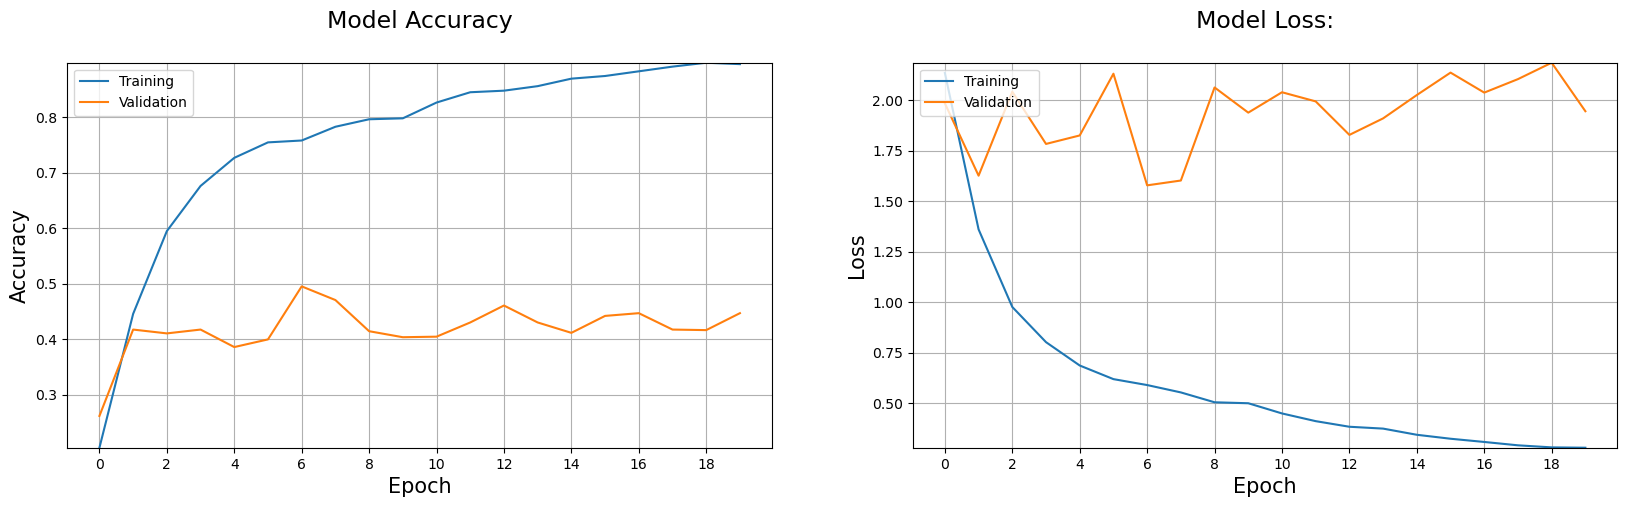

In [138]:
plot_performance(epochs,train_loss,train_acc,CV_loss,CV_acc)

plotting confusion matrix:

In [139]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [140]:
prediction_Y = model(testX_tensor)
pred_Y = torch.argmax(prediction_Y,axis=1)
test_accuracy = accuracy_score(testY_tensor,pred_Y)
test_precision = precision_score(testY_tensor,pred_Y,average='macro') #'macro'：计算每个类别的得分，然后计算它们的平均值（在这里，类别权重相等）。
test_recall = recall_score(testY_tensor,pred_Y,average='macro')
test_f1 = f1_score(testY_tensor,pred_Y,average='macro')
print(f"test accuracy:{test_accuracy:.4f}")
print(f"test_precision:{test_precision:.4f}")
print(f"test_recall:{test_recall:.4f}")
print(f"test F1 score:{test_f1:.4f}")


test accuracy:0.4694
test_precision:0.4278
test_recall:0.4694
test F1 score:0.4127


d:\Miniconda.env\envs\pytorch-cpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
# classification report: 识别在哪些类别上分类表现良好，哪些表现不佳
from sklearn.metrics import classification_report
report = classification_report(testY_tensor,pred_Y)
print(report)

              precision    recall  f1-score   support

         1.0       0.64      0.82      0.72        39
         2.0       0.33      0.03      0.05        39
         3.0       0.24      0.82      0.37        39
         4.0       0.41      0.31      0.35        39
         5.0       0.67      0.36      0.47        39
         6.0       0.54      0.56      0.55        39
         7.0       0.43      0.92      0.59        39
         8.0       0.00      0.00      0.00        39
         9.0       0.79      0.95      0.86        39
        10.0       0.94      0.85      0.89        39
        11.0       0.00      0.00      0.00        39
        12.0       0.42      0.38      0.40        39
        13.0       0.16      0.10      0.12        39

    accuracy                           0.47       507
   macro avg       0.43      0.47      0.41       507
weighted avg       0.43      0.47      0.41       507



d:\Miniconda.env\envs\pytorch-cpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Miniconda.env\envs\pytorch-cpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Miniconda.env\envs\pytorch-cpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


报告中的指标解释如下：

- Precision（精确率）：对于每个类别，表示为**所有被模型正确识别为该类别的样本数**除以**模型预测为该类别的总样本数**。

- Recall（召回率）：也称为真正率或灵敏度，对于每个类别，表示为**所有被模型正确识别为该类别的样本数**除以**实际为该类别的总样本数**。

- F1-score（F1 分数）：精确率和召回率的调和平均数，是一个综合考虑精确率和召回率的指标。

- Support（支持度）：每个类别在 y_true 中的样本数量。

在报告的底部，你还可以看到以下两个整体评估指标：

- Accuracy（准确率）：所有类别中，模型正确预测的样本数占总样本数的比例。

- Macro avg（宏平均）：计算每个类别的指标的简单平均值。它不考虑类别的支持度（样本数量）。

- Weighted avg（加权平均）：计算每个类别的指标的平均值，但是每个类别的指标会乘以它们的支持度（样本数量）作为权重。

In [146]:
conf_matrix = confusion_matrix(testY_tensor,pred_Y)
conf_matrix[:5]

array([[32,  0,  0,  0,  6,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  1, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 32,  0,  0,  4,  0,  0,  0,  1,  0,  0,  2],
       [ 0,  0,  0, 12,  0,  0, 25,  0,  0,  0,  0,  2,  0],
       [16,  1,  0,  0, 14,  1,  0,  0,  6,  0,  0,  1,  0]], dtype=int64)

In [143]:
def plot_conf_matrix(conf_matrix):
    # 绘制混淆矩阵的热力图
    plt.figure(figsize=(8, 6))  # 设置图形的大小
    img = plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues,aspect='auto')  # 使用 'nearest' 插值方法，避免数值模糊
    plt.title('Confusion Matrix')  # 设置图形的标题
    plt.colorbar(img)  # 显示颜色条

    # 在混淆矩阵的每个单元格中添加文本标签
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),  # 'd' 表示整数格式
                    ha="center", va="center", color="red",fontsize=12)

    plt.xlabel('Predicted Label')  # 设置 x 轴的标签 , 测试集sample手势对应的索引
    plt.ylabel('True Label')  # 设置 y 轴的标签, 测试集label手势对应的索引

    # 显示图形
    plt.tight_layout()
    plt.show()

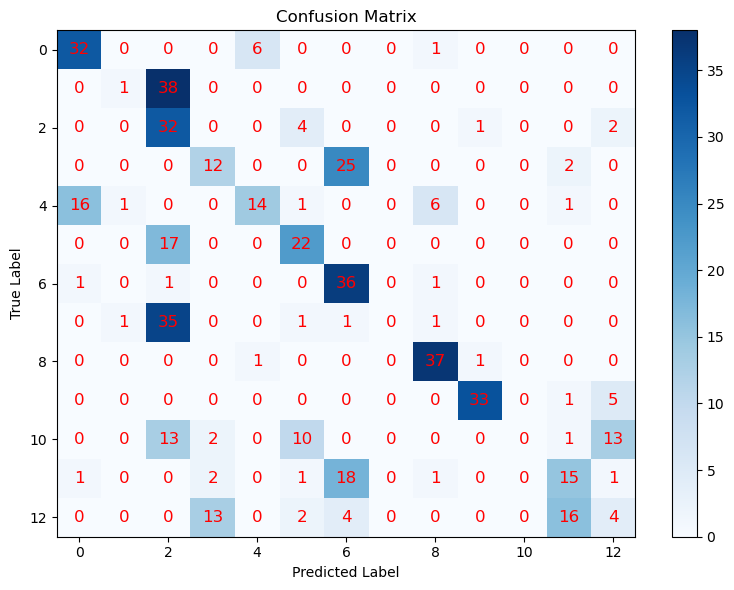

In [144]:
plot_conf_matrix(conf_matrix)